In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from pylab import cm

import os
import sys
import re
import sympy

import cmath
import matplotlib.patches as patches
from matplotlib import colors as m2colors

import plotly.graph_objects as go

from MMfxns import *

cwd = os.getcwd()
sns.set(style="ticks", font_scale=1.5)

mcolors = dict(m2colors.BASE_COLORS, **m2colors.CSS4_COLORS)

saveall = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 0, 'x')

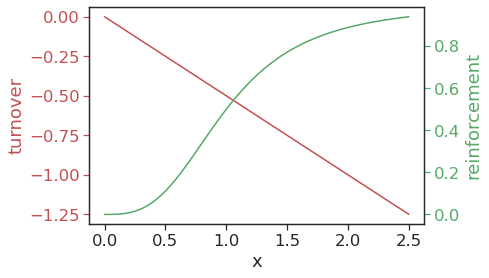

In [3]:
## SI Figure 1
### plot the turnover and self reinforcement terms here w.r.t. x

res = 100
tau = 2
alpha = 1.
n = 3
x_space = np.linspace(0,2.5,res)
turnover = -x_space/tau
reinforce = alpha * x_space ** n / (x_space **n + 1)


fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(x_space, turnover, color='r')
ax.set_ylabel('turnover')
ax.yaxis.label.set_color('r')
ax.tick_params(axis='y', colors='r')

ax2.plot(x_space, reinforce, color='g')
ax2.set_ylabel('reinforcement')
ax2.yaxis.label.set_color('g')
ax2.tick_params(axis='y', colors='g')
# ax2.spines['right']
ax.set_xlabel('x')

/home/ccprice/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/ccprice/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


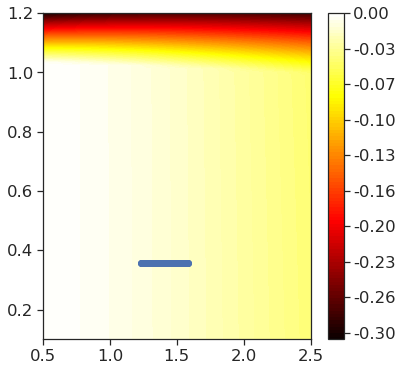

In [15]:
## SI fig 2?

from scipy.signal import argrelextrema

params = {}
params['kc'] = 1.
params['km'] = 'stiff'
params['n'] = 3
params['m0'] = 3.
params['x_c'] = x_crit(params['n'])
params['tau'] = 1.

res = 100
m_space = np.linspace(.1, 1.2, res)
a_space = np.linspace(0.5, 2.5, int(res/1))
x_space = np.linspace(0, 3, res)

x_c = x_crit(n)
a_c = alpha_crit(n, m_space, params)
m_c = scipy.optimize.fsolve(m_crit_general, 0.5, args=(params), xtol=1e-10)[0] / params['m0']

# print('a_c = %f, x_c = %f, m_c = %f' % (a_c, x_c, m_c))

Uma = np.zeros((len(m_space),len(a_space)))
nummins = np.zeros((len(m_space),len(a_space)))

x_guess = np.linspace(np.amin(x_space), np.amax(x_space), 15)

for ai, aa in enumerate(a_space):
    for mi, mm in enumerate(m_space):
        xoutlist = []
        for xi, xx in enumerate(x_guess):
            
            xout = scipy.optimize.fsolve(x_equil, xx, args=(mm, aa, params), xtol=1e-10)[0]
            xout = np.round(xout, 6)
            xoutlist.append(xout)
        
        xoutlist = np.unique(xoutlist)    
        x_stiff = 1-np.exp(-mm/m0)
        Uma[mi,ai] = np.amin(U(f_m, mm, xoutlist, aa, params))

mm, aa = np.meshgrid(m_space,a_space)
        
fig, ax = plt.subplots(1,1,figsize=(6,6))

cf = ax.contourf(aa, mm, Uma, levels=100, cmap=cm.hot)
cb = plt.colorbar(cf, ax=ax, format='%.2f')
ax.scatter(a_c, np.ones(len(a_c)) * m_c / params['m0'])

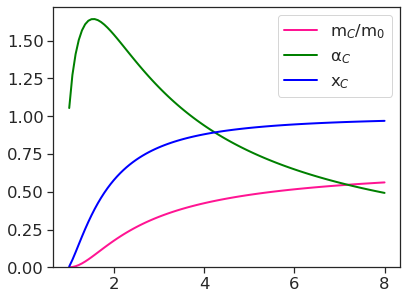

In [14]:
### figure s2
## m_c and a_c vs. n

res = 100

n_space = np.linspace(1.01, 8, res)

def mc_over_m0(n):
    return np.log(1-((n-1)/(n+1))**(1/n)*(1-(2*n/(n+1))))

def ac(n):
    return 4*n/( (n-1)**((n-1)/n) * (n+1)**((n+1)/n) )

def xc(n):
    return ((n-1)/(n+1))**(1/n)

mc_over_n = mc_over_m0(n_space)
ac_over_n = ac(n_space)
xc_over_n = xc(n_space)

fig, ax = plt.subplots(1,1, figsize=(6,4.5))

ax.plot(n_space, mc_over_n, color=mcolors['deeppink'], linewidth=2., label='m$_{C}$/m$_{0}$')
ax.plot(n_space, ac_over_n, color=mcolors['green'], linewidth=2., label='\u03b1$_{C}$')
ax.plot(n_space, xc_over_n, color=mcolors['blue'], linewidth=2., label='x$_{C}$')
ax.set_ylim([0,ax.get_ylim()[1]])

plt.legend()
plt.tight_layout()

# fig2, ax2 = plt.subplots(1,1, figsize=(4,4))


# ax2.set_ylim([0,ax2.get_ylim()[1]])

# plt.tight_layout()


# fig3, ax3 = plt.subplots(1,1, figsize=(4,4))
# ax3.plot(mc_over_n, xc_over_n)
# ax3.plot(m/m0, fm)
# ax3.plot(n_space, xc_over_n)


saveall = False
if saveall:
    direc = os.getcwd() + '/figures/figure2/'
#     direc = os.getcwd() + '/powerpoints/ppt_figs/'

    fname1 = direc + "mc_ac_xc_v1.png"
    print(fname1)
    fig.savefig(fname1, format='png', dpi=600)
    
#     fname1 = direc + "ac_v1.png"
#     print(fname1)
#     fig.savefig(fname1, format='png', dpi=600)

In [ ]:
### figure s3
### arbitrary waddington landscape going from mono to bi stable in 3D

res = 500

x_space = np.linspace(-3, 3, res)
a_space = np.linspace(10, 170, res)

a0 = 0.1
B = -2
g = 0.7
a_c = 150
a_stop = 40

Wscape = np.zeros((res,res))

a_c = np.amax(a_space)/2

ac_ind = np.where(np.abs(a_space - a_c) == np.amin(np.abs(a_space-a_c)))[0]

m0coords = []
m1coords = []
m2coords = []

for ai, aa in enumerate(a_space):
    f0 = -aa**2 * 0.0001
    if aa <= a_c:
        add = np.abs(aa-a_c)/5
    else:
        add = 0.
        
    if aa <= a_stop:
        aa = a_stop
        add = np.abs(a_stop-a_c)/5

    Wscape[ai,:] = add + f0 + a0 * (aa-a_c) * x_space**2 + B/2*(x_space)**4 + 1/3*g*x_space**6
    
    wargs = argrelextrema(np.abs(np.diff(Wscape[ai,:])), np.less)[0]
    x_mins = x_space[wargs]
    if aa <= 111:
#         if len(x_mins) > 1:
        m1coords.append([np.amin(x_mins), a_space[ai], Wscape[ai, np.amin(wargs)]])
        m2coords.append([np.amax(x_mins), a_space[ai], Wscape[ai, np.amax(wargs)]])
#         else:
#             if np.abs(np.amin(x_mins) - m1coords[-1][0]) < np.abs(np.amin(x_mins) - m2coords[-1][0]):
#                 m1coords.append([np.amin(x_mins), aa, Wscape[ai, np.amin(wargs)]])
#             else:
#                 m2coords.append([np.amax(x_mins), aa, Wscape[ai, np.amax(wargs)]])
    else:
        m0coords.append([np.amin(x_mins), aa, Wscape[ai, np.amin(wargs)]])


m0coords = np.array(m0coords);
m1coords = np.array(m1coords); m2coords = np.array(m2coords)        

fig = go.Figure(data=[go.Surface(z=Wscape, x=x_space, y=a_space, colorscale='cividis', 
                                 cmin=np.amin(Wscape), cmax=np.amax(Wscape[-1:])/10)],
               layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
               )

fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                  project_z=False, start=np.amin(Wscape), 
                                  end=np.amax(Wscape), color='black', size=1.5))

fig.add_scatter3d(x=m0coords[:,0], y=m0coords[:,1], z=m0coords[:,2]+0.05, mode='markers', showlegend=False,
                  marker=dict(size=4, color='black'))
fig.add_scatter3d(x=m1coords[:,0], y=m1coords[:,1], z=m1coords[:,2]+0.05, mode='markers', showlegend=False,
                  marker=dict(size=4, color='dodgerblue')) # blueviolet
fig.add_scatter3d(x=m2coords[:,0], y=m2coords[:,1], z=m2coords[:,2]+0.05, mode='markers', showlegend=False,
                  marker=dict(size=4, color='blueviolet')) # dodgerblue

# a_c
ac_ind2 = np.where(np.abs(a_space - 110) == np.amin(np.abs(a_space-110)))[0]
fig.add_scatter3d(x=x_space, y=np.ones(res)*110, z=Wscape[ac_ind2,:].squeeze()+0.01, #np.zeros(res),
                  mode='lines', showlegend=False, line=dict(color='green', width=10))

fig.update_layout(title='Waddington Landscape', autosize=True, scene=dict(
                    xaxis = dict(
                        title='<b>x</b>',
                        titlefont=dict(family='Cambria', size=22), visible=False, showgrid=False, showticklabels=False
                    ),
                    yaxis = dict(
                        title='<b>\u03b1</b>',titlefont=dict(family='Cambria', size=22), visible=False, showgrid=False, showticklabels=False
                    ),
                    zaxis = dict(
                        title='W', range=[np.amin(Wscape)*1.05, np.amax(Wscape[-1:])/12],
                        titlefont=dict(family='Cambria', size=24), visible=False, showgrid=False, showticklabels=False, ticks=''
                    ),
                    ),
                  width=650, height=650,
                  margin=dict(l=50, r=50, b=50, t=50),
                  font=dict(family='Cambria', size=16, color='#7f7f7f'),
                  
                  scene_camera = dict(up = dict(x=0,y=0,z=1), 
                                      center = dict(x=0, y=0, z=0), 
                                      eye = dict(x=0, y=-1.5, z=1.4))
                  
                  )

# print(fig['layout'])#['yaxis']['showgrid'] = False

fig.show()


saveall = False
if saveall:
    direc = os.getcwd() + '/figures/figure1/'    
    fname1 = direc + "sample_waddington_v4_PurpBlueswitch.png"
    fig.write_image(fname1, scale = 1.5, engine='kaleido')